In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import dask.array as da
import time
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import math
import pywt
import scipy
from scipy import ndimage

In [2]:
#Change viewing options
from IPython.core.display import display, HTML
display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

np.set_printoptions(edgeitems=30, linewidth=100000, 
    formatter=dict(float=lambda x: "%.3g" % x))

In [3]:
from dask.distributed import Client
client = Client()  # set up local cluster on your laptop
client

Client Scheduler: tcp://127.0.0.1:34761 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 6.24 GB


In [4]:
#Bring in the whole dataset
start = time.time()
ds = xr.open_mfdataset('/home/ddesantis/Downloads/livneh_NAmerExt_15Oct2014.*.mon.nc')
end = time.time()
print(end - start)

12.39048719406128


# Prepare data for processing

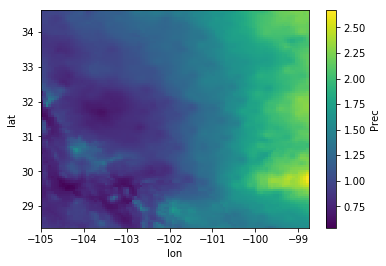

In [55]:
#Create a sub DataArray over smaller area; view some of the data to make sure not all NAN
ds2 = ds.isel(lat=slice(220,320), lon=slice(320,420), time=slice(481, 620))
ds2.Prec.mean('time').plot()

# Define functions in package

# Clustering for DWT

In [6]:
def filter_out_nan(shaped):
    '''This function filters out nan values from a matrix nxm, and saves the index for threading back together'''
    data = []
    index = []
    index_nan = []
    count = 0
    for p in range(shaped.shape[0]):
        if np.isnan(shaped[p][0]):  #check if nan
            index_nan.append(count)
            count = count +1
        else:
            data.append(shaped[p])
            index.append(count)
            count = count + 1    
            
    data = da.stack(data, axis=0)
    return data, index, index_nan

In [7]:
def filter_in_nan(classes, index, index_nan):
    '''The inverse function of filter_out_nan - used to put nan values back into set after clustering'''
    classes_nan = np.ones(len(index_nan))*np.nan
    classes = np.append(classes, classes_nan)


    index_all = index + index_nan
    index_all = np.array(index_all)

    classes = classes[np.argsort(index_all)]
    
    return classes

In [110]:
#Function to compute single level for feature data
def single_level_class(data_set, feature, level, wavelet='haar', metric='euclidean', n_neighbors=3, eps_percentile=98, ratio_dwt=0.001):
    '''The following code computes one level of WaveScan'''
    
    startt=time.time()
    
    lvl = str(level)
    print("LEVEL: " + lvl)
    
    #Compute DWT
    start = time.time()
    wp = pywt.wavedecn(data=data_set[feature].data, wavelet=wave, level = min(level,max_level), mode='constant')
    end = time.time()
    diff = str(end-start)
    print("DWT:" + diff)
    
    #Reshape the data for DBScan
    start = time.time()
    shaped = np.reshape(wp[0], (wp[0].shape[0], wp[0].shape[1]*wp[0].shape[2]))
    shaped = np.transpose(shaped)
    shaped.shape
    
    #Filter out the nan values for clustering
    data, index, index_nan = filter_out_nan(shaped)
    
    end = time.time()
    diff = str(end-start)
    print("Prep Data:" + diff)
    #Discover the epsilon for DBScan using knn. 
    start = time.time()
    
    nbrs = NearestNeighbors(n_neighbors=n_neighbors, metric=metric, algorithm='ball_tree').fit(data)
    distances, indices = nbrs.kneighbors(data)

    #Set the distance to use as within eps_percentile:
    epsilon = np.percentile(distances[:,[1,-1]], eps_percentile)
    print(epsilon)
    
    #Choose the min cluster size.  This is done by setting a percent of the size of the DWT coefficents (as long as it is
    # at least 2).
    min_size = max(np.ceil(data.shape[0]*ratio_dwt), 2)
    end = time.time()
    diff = str(end-start)
    print("Find Params:" + diff)
    
    #Perform db scan and return the result
    start = time.time()
    classes = DBSCAN(eps=epsilon, min_samples=min_size, metric=metric).fit_predict(data)
    end = time.time()
    diff = str(end-start)
    print("DBSCAN:" + diff)
    
    #Filter back in the nan values before reshaping:
    start = time.time()
    classes = filter_in_nan(classes, index, index_nan)
    
    #Reshape classes to match back up with original
    classes = np.reshape(classes, (wp[0].shape[1], wp[0].shape[2]))
    
    end = time.time()
    diff = str(end-start)
    print("Find Classes:" + diff)
    
    
    endt = time.time()
    difft = str(endt - startt)
    print("TOTAL: " + difft)
    print("")
    
    return classes

# Index maps to return labels to initial data

In [9]:
#First, dwt_length is run to compute the length of each wavelet transform level.  This information is used to build the functions that will map the index up one level in the DWT (map_back_index)

In [10]:
#Record the lengths of the data at each wavelet transform.  This function is run outside map_back_classes
def dwt_length(data, wavelet):
    
    dwt_lengths = [data.size]
    max_level = pywt.dwt_max_level(data_len = data.size, filter_len = pywt.Wavelet(wave).dec_len)
    
    for i in range(max_level):
        l = pywt.dwt_coeff_len(dwt_lengths[i], pywt.Wavelet(wave).dec_len, mode='symmetric')
        dwt_lengths.append(l)
    
    return dwt_lengths

In [11]:
def middle_match(data_len,wavelet):
    
    #Grab the filter and its length
    w_fil = pywt.Wavelet(wavelet).dec_lo
    w_fil = np.array(w_fil)
    w_fil = np.flip(w_fil, axis=0)
    w_len = pywt.Wavelet(wavelet).dec_len
    
    #Build the first row of the matrix
    I_m = np.zeros(data_len)
    I_m[:w_len] = w_fil
    
    #Make the shift matrix
    row_number = int(np.ceil((data_len-w_len)/2))
    if data_len%2 == 0:
        for j in range(1, row_number+1):
            row = np.zeros(data_len)
            row[2*j:w_len + 2*j]= w_fil
            I_m = np.concatenate((I_m,row), axis=0)
    
        I_m = np.reshape(I_m, (row_number+1,data_len))
    else:
        for j in range(1, row_number):
            row = np.zeros(data_len)
            row[2*j:w_len + 2*j]= w_fil
            I_m = np.concatenate((I_m,row), axis=0)
    
        I_m = np.reshape(I_m, (row_number,data_len))        
        
        
    return I_m

In [12]:
def top_match(data_len, wavelet):
    
    #Grab the filter and its length
    w_fil = pywt.Wavelet(wavelet).dec_lo
    w_fil = np.array(w_fil)
    w_fil = np.flip(w_fil, axis=0)
    w_len = pywt.Wavelet(wavelet).dec_len
    
    #Build blank matrix
    row_number = int(np.ceil((w_len)/2))
    I_t = np.zeros((row_number-1,data_len))
    
    #Make the shift matrix
    for j in range(1,row_number):
        overflow = w_fil[:2*j]
        overflow = np.flip(overflow, axis=0)
        row_o = np.zeros(data_len)
        row_o[:2*j] = overflow
        
        leftover = w_fil[2*j:]
        row_l = np.zeros(data_len)
        row_l[:leftover.size] = leftover
        
        row = row_o + row_l      
        
        I_t[j-1] = row
    
    return I_t

In [13]:
def bot_match(data_len, wavelet):
   
    #Grab the filter and its length
    w_fil = pywt.Wavelet(wavelet).dec_lo
    w_fil = np.array(w_fil)
    w_fil = np.flip(w_fil, axis=0)
    w_len = pywt.Wavelet(wavelet).dec_len

    row_number = int(np.ceil((w_len)/2))
    if data_len%2 ==0:
        I_b = np.zeros((row_number-1,data_len))
        for j in range(1,row_number):
            overflow = w_fil[-2*j:]
            overflow = np.flip(overflow, axis=0)
            row_o = np.zeros(data_len)
            row_o[-2*j:] = overflow
            
            
            leftover = w_fil[:-2*j]
            row_l = np.zeros(data_len)
            row_l[-leftover.size:] = leftover
            
            row = row_o + row_l
            
            I_b[j-1] = row         
    else:
        I_b = np.zeros((row_number,data_len))
        for j in range(1,row_number+1):         
            overflow = w_fil[-2*j+1:]
            overflow = np.flip(overflow, axis=0)
            row_o = np.zeros(data_len)
            row_o[-2*j+1:] = overflow
            
            leftover = w_fil[:-2*j+1]
            row_l = np.zeros(data_len)
            row_l[-leftover.size:] = leftover

            
            row = row_o + row_l
            
            I_b[j-1] = row
            
    return I_b

In [14]:
#Function used to build filter matrix for mapping classes back one level
def filter_matrix(data_len, wavelet):
    
    I_m = middle_match(data_len, wavelet)
    I_t = top_match(data_len, wavelet)
    I_b = bot_match(data_len, wavelet)
    
    I = np.concatenate((I_t,I_m), axis=0)
    I = np.concatenate((I,I_b), axis=0)
    
    return I

In [15]:
#Function used to discover classes at one stage higher resolution
def map_back_index(wavelet, dwt_lengths, max_level):
    
    index_up=[]
    
    for j in range(max_level):
        I = filter_matrix(dwt_lengths[j], wavelet)
        I = np.abs(I)
        classes_index = np.argmax(I,axis=0)
        index_up.append(classes_index)
        
    return index_up

# Having clustered, we now map each class back to initial data

In [16]:
def map_back_classes(data_classes, index_up, max_level):
    
    final_class = []
    for j in range(max_level):
        classt = data_classes[j]
        for i in range(j+1):
            classt = classt[index_up[j-i]][:,index_up[j-i]]
        final_class.append(classt)
        
    return final_class

# Set up Wavelet Transform

In [38]:
#pywt.wavelist()
#Information : http://wavelets.pybytes.com/
print(pywt.Wavelet('haar'))

Wavelet haar
  Family name:    Haar
  Short name:     haar
  Filters length: 2
  Orthogonal:     True
  Biorthogonal:   True
  Symmetry:       asymmetric
  DWT:            True
  CWT:            False


In [111]:
#Set the number of levels for DWT, as well as the wavelet
min_len = min(ds2.Prec.data.shape)
wave = 'db2'

#figure out max possible levels to loop over given size of data
max_level = pywt.dwt_max_level(data_len = min_len, filter_len = pywt.Wavelet(wave).dec_len) 
max_level

5

In [112]:
#dwt_lengths need to be computed for both lat and lon.
dwt_lengths = dwt_length(ds2.lat, wave)
dwt_lengths

[100, 51, 27, 15, 9, 6]

In [113]:
index_up = map_back_index(wave,dwt_lengths,max_level)
index_up

[array([ 0,  1,  2,  2,  3,  3,  4,  4,  5,  5,  6,  6,  7,  7,  8,  8,  9,  9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 20, 20, 21, 21, 22, 22, 23, 23, 24, 24, 25, 25, 26, 26, 27, 27, 28, 28, 29, 29, 30, 30, 31, 31, 32, 32, 33, 33, 34, 34, 35, 35, 36, 36, 37, 37, 38, 38, 39, 39, 40, 40, 41, 41, 42, 42, 43, 43, 44, 44, 45, 45, 46, 46, 47, 47, 48, 48, 49, 49, 50, 50]),
 array([ 0,  1,  2,  2,  3,  3,  4,  4,  5,  5,  6,  6,  7,  7,  8,  8,  9,  9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 20, 20, 21, 21, 22, 22, 23, 23, 24, 24, 25, 25, 26]),
 array([ 0,  1,  2,  2,  3,  3,  4,  4,  5,  5,  6,  6,  7,  7,  8,  8,  9,  9, 10, 10, 11, 11, 12, 12, 13, 13, 14]),
 array([0, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8]),
 array([0, 1, 2, 2, 3, 3, 4, 4, 5])]

In [114]:
#Not quite right...currently maps back only if lat lon have same size.  Want to do above for each dimension

# Test on climate data

In [115]:
#Gather all the Prec classes for each level:
%reset_selective -f Prec_classes

Prec_classes = []
for i in range(1,max_level+1):
    classes = single_level_class(ds2, feature = 'Prec', level = i)
    Prec_classes.append(classes)

LEVEL: 1
DWT:0.4737701416015625
Prep Data:0.4735400676727295
5.034947558815121
Find Params:14.68297529220581
DBSCAN:7.69627833366394
Find Classes:0.0006389617919921875
TOTAL: 23.32835865020752

LEVEL: 2
DWT:0.8398265838623047
Prep Data:0.11392736434936523
13.39096259875052
Find Params:3.565105438232422
DBSCAN:2.215801239013672
Find Classes:0.00015783309936523438
TOTAL: 6.735983371734619

LEVEL: 3
DWT:0.6949405670166016
Prep Data:0.03432464599609375
36.7273733641725
Find Params:1.1573772430419922
DBSCAN:0.6180741786956787
Find Classes:0.0003314018249511719
TOTAL: 2.5072569847106934

LEVEL: 4
DWT:0.6506719589233398
Prep Data:0.013390541076660156
99.13089168982809
Find Params:0.4741702079772949
DBSCAN:0.2763824462890625
Find Classes:0.0001289844512939453
TOTAL: 1.4150879383087158

LEVEL: 5
DWT:0.6531517505645752
Prep Data:0.00556492805480957
235.20691355451402
Find Params:0.7541239261627197
DBSCAN:0.15738630294799805
Find Classes:7.43865966796875e-05
TOTAL: 1.5706839561462402



In [116]:
Prec_classes = map_back_classes(Prec_classes, index_up, max_level)

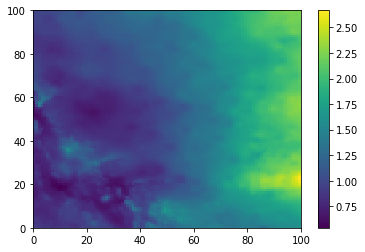

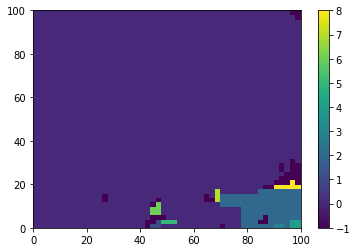

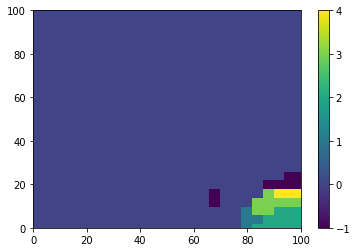

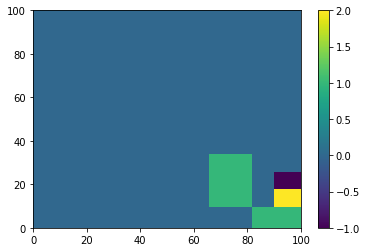

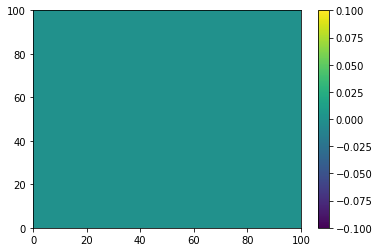

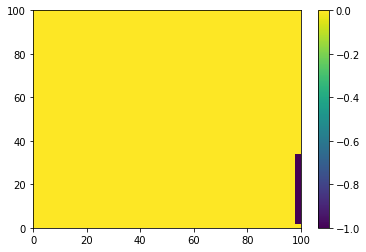

In [117]:
#Plot the different levels of classification verses the historical average:
plt.figure(-1)
p = plt.pcolormesh(ds2.Prec.mean('time').data)
plt.colorbar(p)

for i in range(0,max_level):
    plt.figure(i)
    p = plt.pcolormesh(Prec_classes[i])
    plt.colorbar(p)

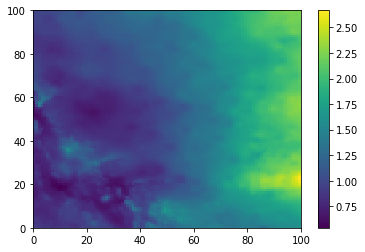

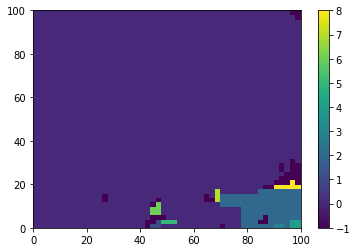

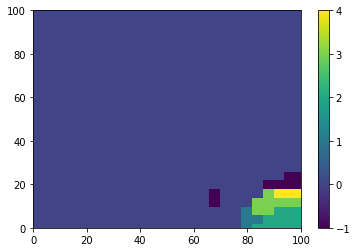

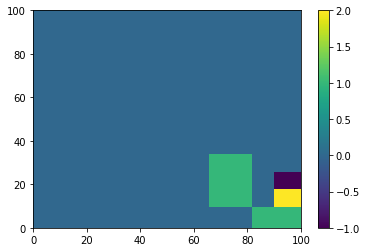

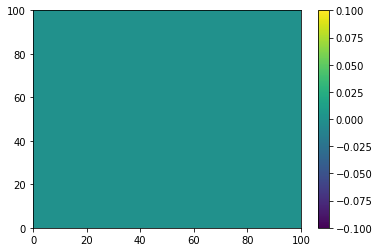

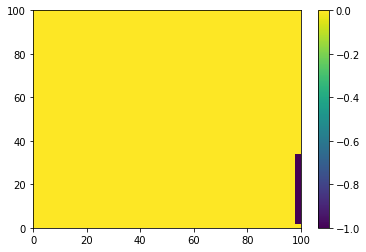

In [118]:
#Plot the different levels of classification verses the historical average:
plt.figure(-1)
p = plt.pcolormesh(ds2.Prec.mean('time').data)
plt.colorbar(p)

for i in range(0,max_level):
    plt.figure(i)
    p = plt.pcolormesh(Prec_classes[i])
    plt.colorbar(p)

In [52]:
#Gather all the Prec classes for each level:
%reset_selective -f Prec_classes

Prec_classes = []
for i in range(1,max_level+1):
    classes = single_level_class(ds2, feature = 'Prec', level = i)
    Prec_classes.append(classes)

LEVEL: 1
DWT:0.7868547439575195
Prep Data:0.413407564163208


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


Find Params:14.42497730255127


distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)


DBSCAN:7.462890386581421
Find Classes:0.0005309581756591797
TOTAL: 23.08938956260681

LEVEL: 2
DWT:1.1580538749694824
Prep Data:0.11428642272949219


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


Find Params:3.7776505947113037


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


DBSCAN:1.9324958324432373
Find Classes:0.00016069412231445312
TOTAL: 6.993328332901001

LEVEL: 3
DWT:1.0198585987091064
Prep Data:0.03615689277648926
Find Params:1.0458629131317139


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


DBSCAN:0.8814234733581543
Find Classes:0.0002396106719970703
TOTAL: 2.9847147464752197

LEVEL: 4
DWT:1.0548508167266846
Prep Data:0.016199350357055664
Find Params:0.5100467205047607
DBSCAN:0.3159472942352295
Find Classes:0.00012230873107910156
TOTAL: 1.8975918292999268

LEVEL: 5
DWT:0.9140949249267578
Prep Data:0.005556344985961914
Find Params:0.2913830280303955
DBSCAN:0.1262831687927246
Find Classes:7.581710815429688e-05
TOTAL: 1.3383150100708008



In [53]:
Prec_classes = map_back_classes(Prec_classes, index_up, max_level)

In [56]:
#Gather all the Prec classes for each level:
%reset_selective -f Prec_classes

Prec_classes = []
for i in range(1,max_level+1):
    classes = single_level_class(ds2, feature = 'Prec', level = i)
    Prec_classes.append(classes)

LEVEL: 1
DWT:0.559105396270752
Prep Data:0.4223439693450928


distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)


Find Params:15.422499179840088
DBSCAN:7.835937261581421
Find Classes:0.0008132457733154297
TOTAL: 24.241167545318604

LEVEL: 2
DWT:0.8790810108184814
Prep Data:0.10993313789367676
Find Params:4.0591630935668945
DBSCAN:2.124040126800537
Find Classes:0.0003440380096435547
TOTAL: 7.174085855484009

LEVEL: 3
DWT:0.7463634014129639
Prep Data:0.03525257110595703
Find Params:1.4716176986694336
DBSCAN:0.5584301948547363
Find Classes:0.00012969970703125
TOTAL: 2.812391996383667

LEVEL: 4
DWT:0.6320071220397949
Prep Data:0.012782573699951172
Find Params:0.5065786838531494
DBSCAN:0.27469301223754883
Find Classes:8.0108642578125e-05
TOTAL: 1.426572322845459

LEVEL: 5
DWT:0.5996677875518799
Prep Data:0.0057468414306640625
Find Params:0.30732202529907227
DBSCAN:0.10193419456481934
Find Classes:7.605552673339844e-05
TOTAL: 1.0156326293945312



In [57]:
Prec_classes = map_back_classes(Prec_classes, index_up, max_level)

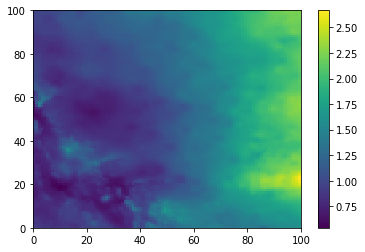

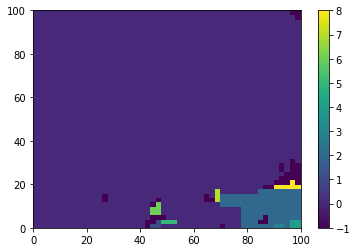

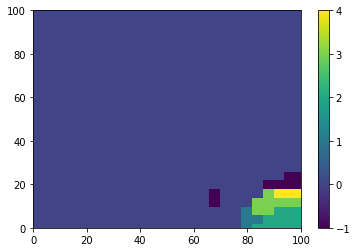

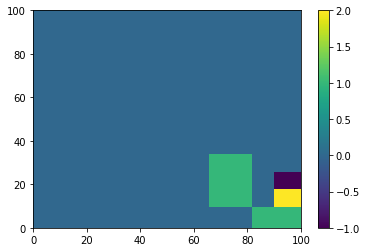

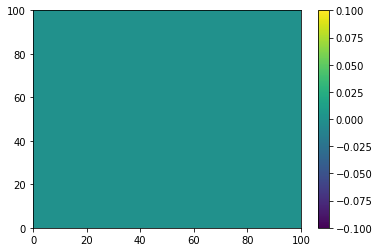

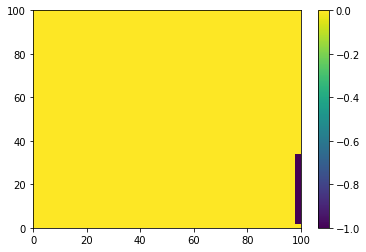

In [58]:
#Plot the different levels of classification verses the historical average:
plt.figure(-1)
p = plt.pcolormesh(ds2.Prec.mean('time').data)
plt.colorbar(p)

for i in range(0,max_level):
    plt.figure(i)
    p = plt.pcolormesh(Prec_classes[i])
    plt.colorbar(p)

In [33]:
#Gather all the Prec classes for each level:
%reset_selective -f Tmax_classes

Tmax_classes = []
for i in range(1,max_level+1):
    classes = single_level_class(ds2, feature = 'Prec', level = i)
    Tmax_classes.append(classes)

LEVEL: 1
DWT:1.1249666213989258


distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


Prep Data:1.7393975257873535


distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

Find Params:54.34904360771179


distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


DBSCAN:35.510892391204834
Find Classes:0.001497507095336914
TOTAL: 92.72625875473022

LEVEL: 2
DWT:2.2430577278137207


distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)


Prep Data:0.3642768859863281


distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


Find Params:11.659772634506226


distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


DBSCAN:6.421743631362915
Find Classes:0.0005199909210205078
TOTAL: 20.689908504486084

LEVEL: 3


distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


DWT:1.453622579574585
Prep Data:0.37346434593200684


distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)


Find Params:3.3507120609283447


distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


DBSCAN:1.8764607906341553
Find Classes:0.000194549560546875
TOTAL: 7.0550689697265625

LEVEL: 4
DWT:1.2740075588226318
Prep Data:0.03261828422546387


distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)


Find Params:1.2834925651550293
DBSCAN:0.5719084739685059
Find Classes:0.0004296302795410156
TOTAL: 3.1632325649261475

LEVEL: 5
DWT:1.2099158763885498
Prep Data:0.012312173843383789
Find Params:0.469163179397583
DBSCAN:0.26831531524658203
Find Classes:8.797645568847656e-05
TOTAL: 1.9609334468841553



In [34]:
Tmax_classes = map_back_classes(Tmax_classes, index_up, max_level)

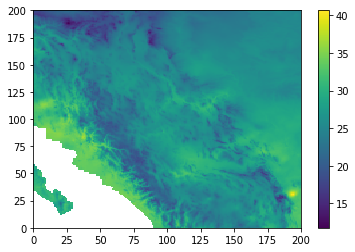

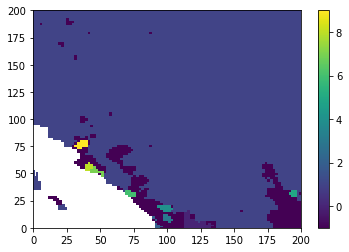

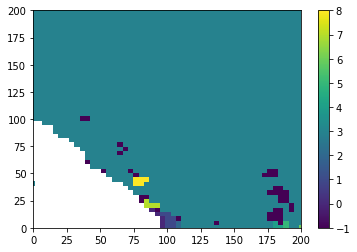

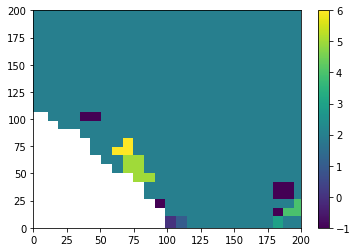

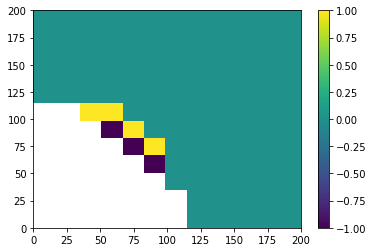

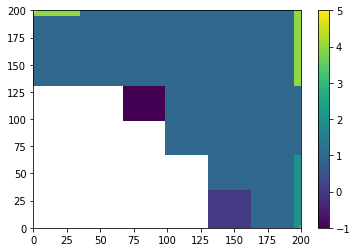

distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


In [35]:
plt.figure(-1)
p = plt.pcolormesh(ds2.Tmax.mean('time').data)
plt.colorbar(p)

for i in range(0,max_level):
    plt.figure(i)
    p = plt.pcolormesh(Tmax_classes[i])
    plt.colorbar(p)